In [8]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))
sys.path.append(str(Path(os.getcwd()).parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
IDX = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate an example circuit

In [21]:
H = np.loadtxt("../data/hgp_check_matrices/(3,4)_n225_k9_d6/example.txt")
H = H.astype("uint8")

In [27]:
from build_random_hgp_circuits import compute_hgp_code_parameters

code, code_prms = compute_hgp_code_parameters(H, H)

print(code_prms)

(225, 9, 6)


In [40]:
from build_random_hgp_circuits import build_hgp_circuit_from_code

dv, dc = 3, 4
n, k, d = code_prms
T = d
p = 1e-3

# Create circuit
circuit = build_hgp_circuit_from_code(code, p, T)

In [42]:
# Save circuit
circuit_dir = "../data/hgp_prebuilt/circuits"
circuit_subdir = os.path.join(circuit_dir, f"({dv},{dc})_n{n}_k{k}_d{d}_T{T}_p{p}")
os.makedirs(circuit_subdir, exist_ok=True)
circuit.to_file(os.path.join(circuit_subdir, f"example.stim"))

## pfail vs pabort

In [1]:
from plotting_helpers import load_ps_data

filter = {"n": 225, "k": 9, "d": 6}
df_ps_dict = load_ps_data("hgp", filter=filter)

In [3]:
from plotting_helpers import aggregate_seeds

df_ps_best_seed_dict = {}
for by, df_ps in df_ps_dict.items():
    df_ps_best_seed_dict[by] = aggregate_seeds(df_ps, use_pfail_upper=False)

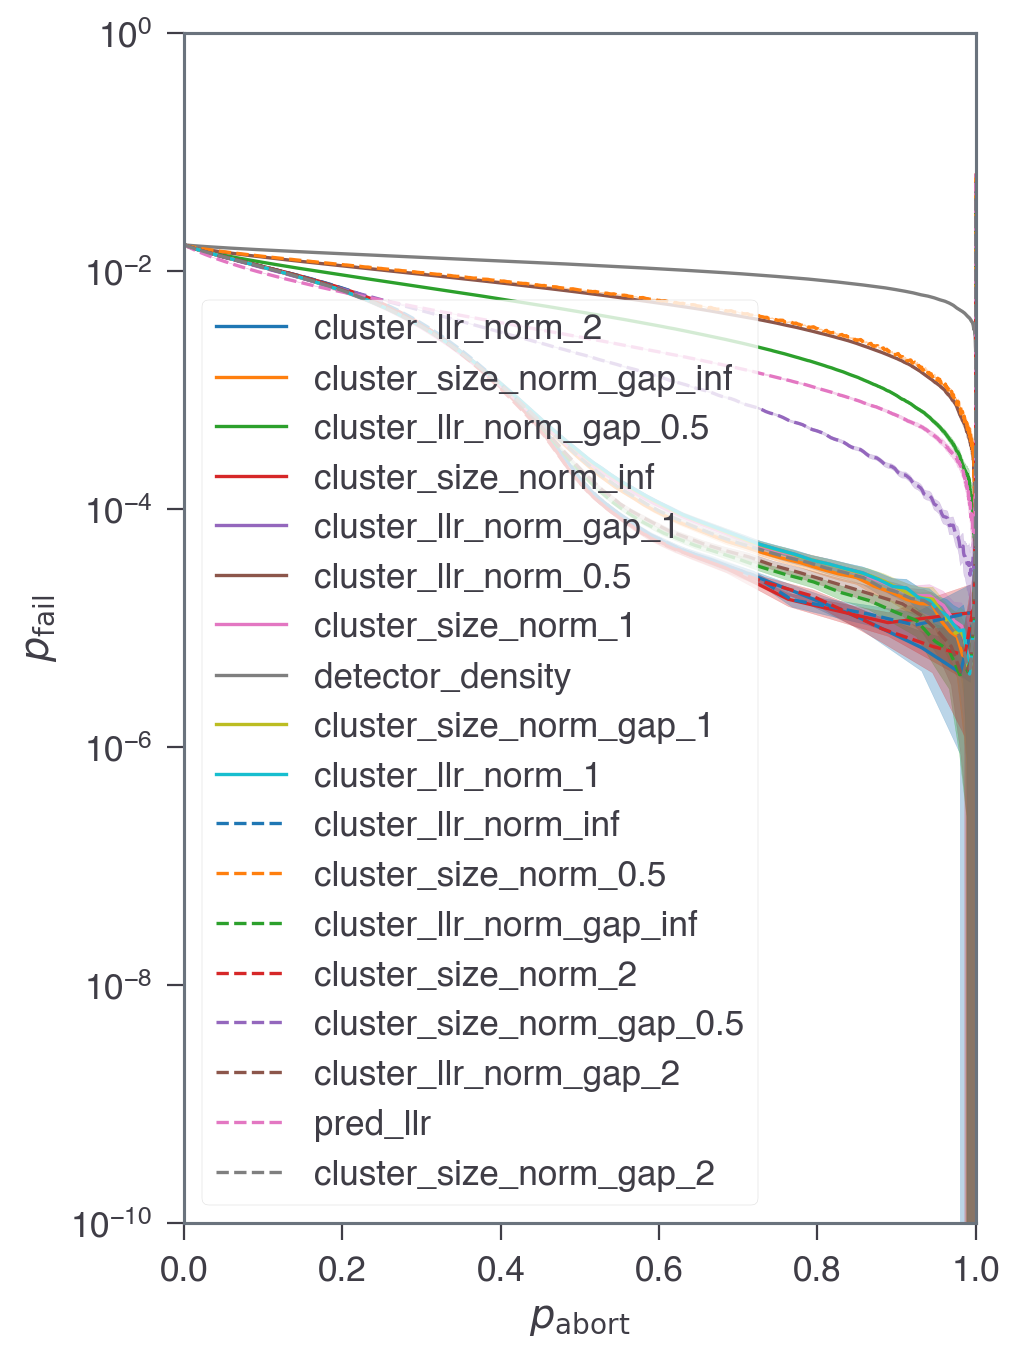

In [6]:
from plotting_helpers import error_band_plot

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 7))

prms = (225, 9, 6, 6, 1e-3)
T = prms[3]

i = 0
data_plots = {}
for by, df_ps_all in df_ps_dict.items():
    if True:
        p_abort_col = "p_abort"
        p_fail_col = "p_fail"
        delta_p_fail_col = "delta_p_fail"

        # df_ps = df_ps_all.loc[idx[n, T, p, :], :].reset_index()
        df_ps = df_ps_all.reset_index()

        df_ps = df_ps.sort_values(by=p_abort_col)
        p_abort = df_ps[p_abort_col].values
        p_fail = df_ps[p_fail_col].values / T
        delta_p_fail = df_ps[delta_p_fail_col].values / T
        data_plots[by] = (p_abort, p_fail, delta_p_fail)

        error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i % 10),
            linestyle="-" if i < 10 else "--",
            label=by,
            ax=ax,
        )
        i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

0: cluster_size_norm_2 (1.76e-04 ± 4.73e-06)
1: cluster_size_norm_inf (1.81e-04 ± 4.79e-06)
2: cluster_llr_norm_2 (1.86e-04 ± 4.87e-06)
3: cluster_llr_norm_inf (1.88e-04 ± 4.89e-06)
4: cluster_llr_norm_gap_inf (2.18e-04 ± 5.26e-06)
5: cluster_llr_norm_gap_2 (2.39e-04 ± 5.50e-06)
6: cluster_size_norm_gap_inf (2.67e-04 ± 5.83e-06)
7: cluster_size_norm_1 (2.97e-04 ± 6.13e-06)
8: cluster_size_norm_gap_2 (2.97e-04 ± 6.12e-06)
9: cluster_size_norm_gap_1 (3.02e-04 ± 6.21e-06)
10: cluster_llr_norm_gap_1 (3.29e-04 ± 6.44e-06)
11: cluster_llr_norm_1 (3.29e-04 ± 6.44e-06)
12: cluster_size_norm_gap_0.5 (2.03e-03 ± 1.60e-05)
13: pred_llr (2.80e-03 ± 1.88e-05)
14: cluster_llr_norm_gap_0.5 (4.57e-03 ± 2.38e-05)
15: cluster_llr_norm_0.5 (6.65e-03 ± 2.86e-05)
16: cluster_size_norm_0.5 (6.94e-03 ± 2.92e-05)
17: detector_density (1.15e-02 ± 3.64e-05)


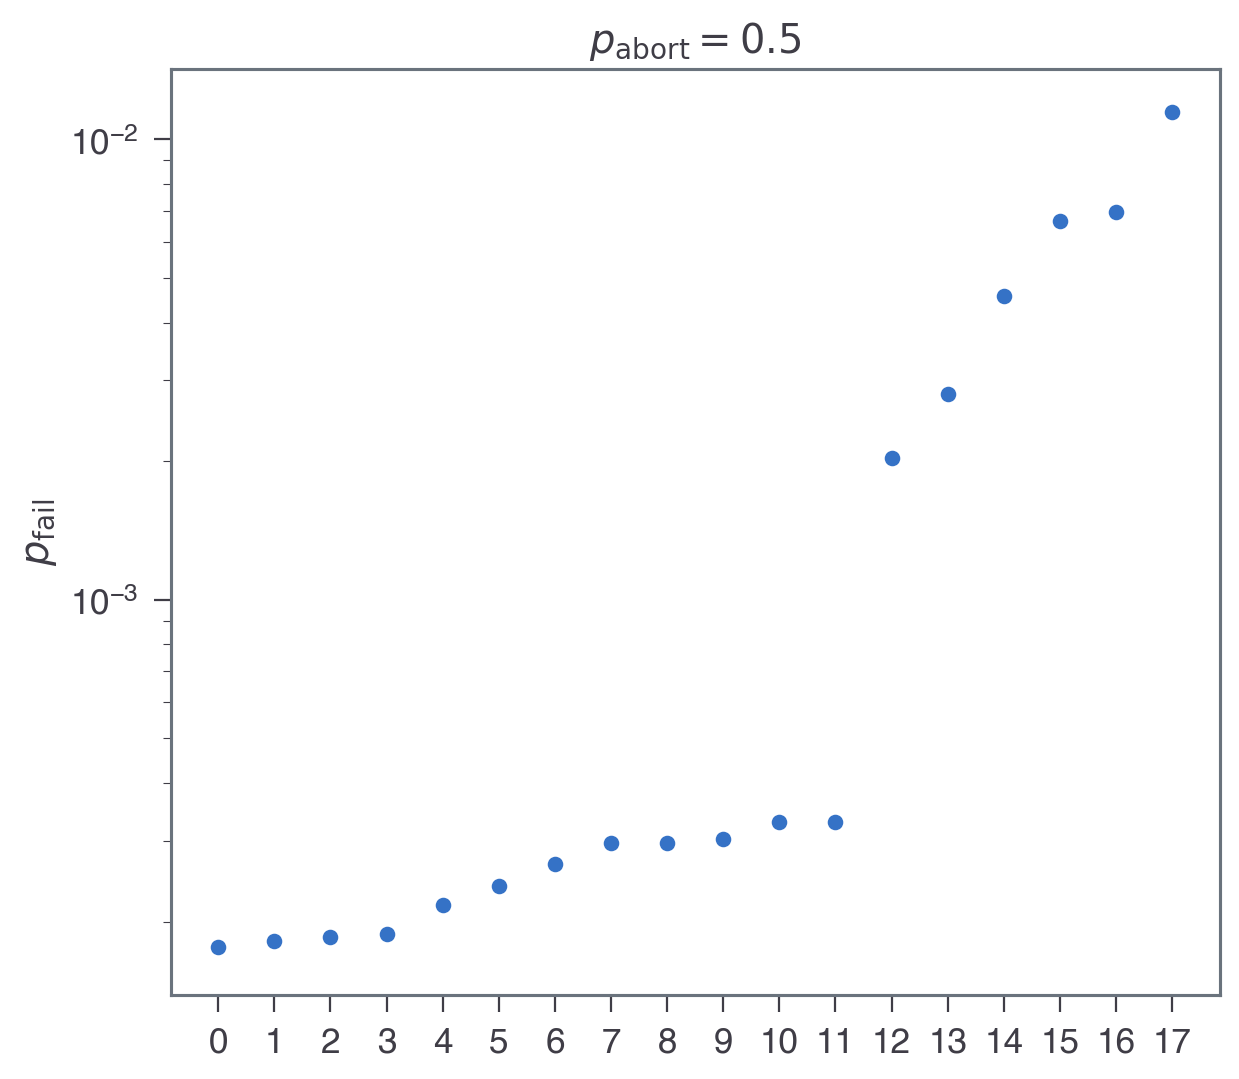

In [7]:
target = 0.5
bys, y_vals, y_errs = [], [], []

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    idx = np.where(p_abort <= target)[0]
    if len(idx):
        sel = idx[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")

x_pos = np.arange(len(bys))

plt.errorbar(
    x_pos,
    y_vals_sorted,
    yerr=y_errs_sorted,
    fmt="o",
    capsize=5,
    lw=1.5,
    markeredgecolor="k",
)
plt.title(rf"$p_\mathrm{{abort}} = {target}$")
plt.xticks(x_pos, x_pos)
plt.ylabel(r"$p_{\mathrm{fail}}$")
plt.yscale("log")
plt.tight_layout()
plt.show()